In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/model.py /content
# !cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 6\ Assignment/utils.py /content

In [ ]:
# import model
# import utils
# from model import Net
# from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True


In [2]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) --> This is incorrect line and hence commented
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [3]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [4]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [5]:
batch_size = 128

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} --> Commented the incorrect line. shuffle parameter needs to be True
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs) --> Commented the incorrect line. test_data needs be passed for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

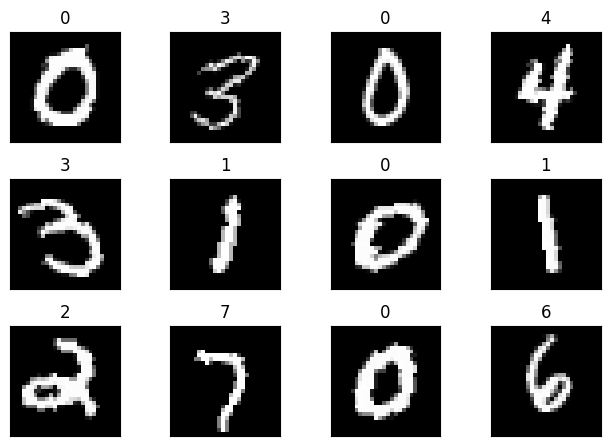

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [7]:
from tqdm import tqdm

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

This was original structure in assignment 6 submission

In [ ]:
# class Net(nn.Module):
#     #This defines the structure of the NN.
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Dropout(0.1)
#         ) # 28*28*128

#         self.trans1 = nn.Sequential(
#             nn.Conv2d(128, 8, 1, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(0.1)
#         ) # 30*30*8

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(8, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1),
#             nn.MaxPool2d(2, 2)
#         ) # 30*30*16 | 15*15*16

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1)
#         ) # 15*15*16

#         self.conv4 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.1),
#             nn.MaxPool2d(2, 2)
#         ) # 15*15*32 | 7*7*32

#         self.trans2 = nn.Sequential(
#             nn.Conv2d(32, 16, 1, padding=1)
#         ) # 9*9*32

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1)
#         ) # 9**9*16

#         self.conv6 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, padding=1), # 1*1
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.1)
#         ) # 9*9*32

#         self.conv7 = nn.Sequential(
#             nn.Conv2d(32, 10, 1, padding=1),
#             nn.AvgPool2d(kernel_size=7)
#         ) # 11*11*10 | 1*1*10

#     def forward(self, x):
#       x = self.conv1(x)
#       #print("size after 1st layer: " ,x.shape)
#       x = self.trans1(x)
#       x = self.conv2(x)
#       #print("size after 2nd layer: " ,x.shape)
#       x = self.conv3(x)
#       #print("size after 3rd layer: " ,x.shape)
#       x = self.conv4(x)
#       x = self.trans2(x)
#       x = self.conv5(x)
#       x = self.conv6(x)
#       x = self.conv7(x)
#       #print("size after 4th layer: " ,x.shape)
#       x = x.view(x.size(0), -1)
#       #print("size after flattening: " ,x.shape)
#       x = F.log_softmax(x, dim=1)
#       return x

Modifed structure below

In [10]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # 26*26*16

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
        ) # 24*24*32

        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # 24*24*10

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2)
        ) # 22*22*16 | 11*11*16

        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
        ) # 9*9*32

        self.conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            #nn.MaxPool2d(2, 2)
        ) # 7*7*32

        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 16, 1, padding=0)
        ) # 7*7*16

        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            #nn.MaxPool2d(2, 2)
        ) # 5*5*16

        self.conv7 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0), # 1*1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # 3*3*16

        self.conv8 = nn.Sequential(
            nn.Conv2d(16, 10, 1, padding=0),
            nn.AvgPool2d(kernel_size=3)
        ) # 3*3*10 | 1*1*10

    def forward(self, x):
      x = self.conv1(x)
      #print("size after 1st layer: " ,x.shape)
      x = self.conv2(x)
      x = self.trans1(x)
      x = self.conv3(x)
      #print("size after 2nd layer: " ,x.shape)
      x = self.conv4(x)
      #print("size after 3rd layer: " ,x.shape)
      x = self.conv5(x)
      x = self.trans2(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8(x)
      #print("size after 4th layer: " ,x.shape)
      x = x.view(x.size(0), -1)
      #print("size after flattening: " ,x.shape)
      x = F.log_softmax(x, dim=1)
      return x

In [11]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [12]:
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    #loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

In [13]:
def test(model, device, test_loader,criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,640
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             330
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
          Dropout-12           [-1, 10, 24, 24]               0
           Conv2d-13           [-1, 16, 22, 22]           1,456
             ReLU-14           [-1, 16,

In [16]:
import torch.optim.lr_scheduler as lrs

In [17]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9) -- Commented the line since learning rate needs to be corrected
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = lrs.ReduceLROnPlateau(optimizer, 'min',patience = 3, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
#criterion = F.nll_loss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  #test(model, device, train_loader) --> Removed this incorrect line. test_loader needs to be passed here
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0824 Batch_id=468 Accuracy=91.16: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]


Test set: Average loss: 0.0612, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0349 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]


Test set: Average loss: 0.0408, Accuracy: 9875/10000 (98.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1344 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]


Test set: Average loss: 0.0341, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0206 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0274 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]


Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0037 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0259 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0052 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0420 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0153 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0272 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0828 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0054 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]


Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0046 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0078 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16


Train: Loss=0.0340 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.0161 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0090 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 19


Train: Loss=0.0348 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 20


Train: Loss=0.0148 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-05.


In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

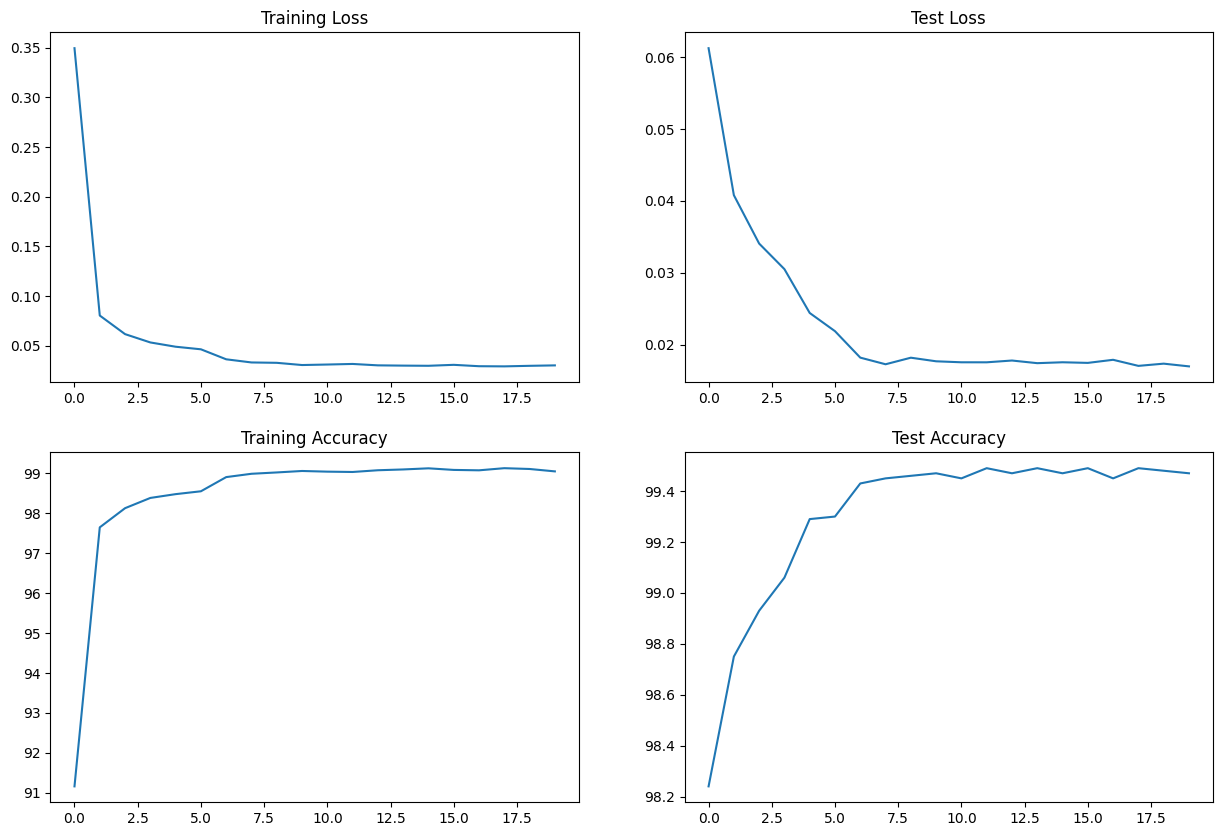

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

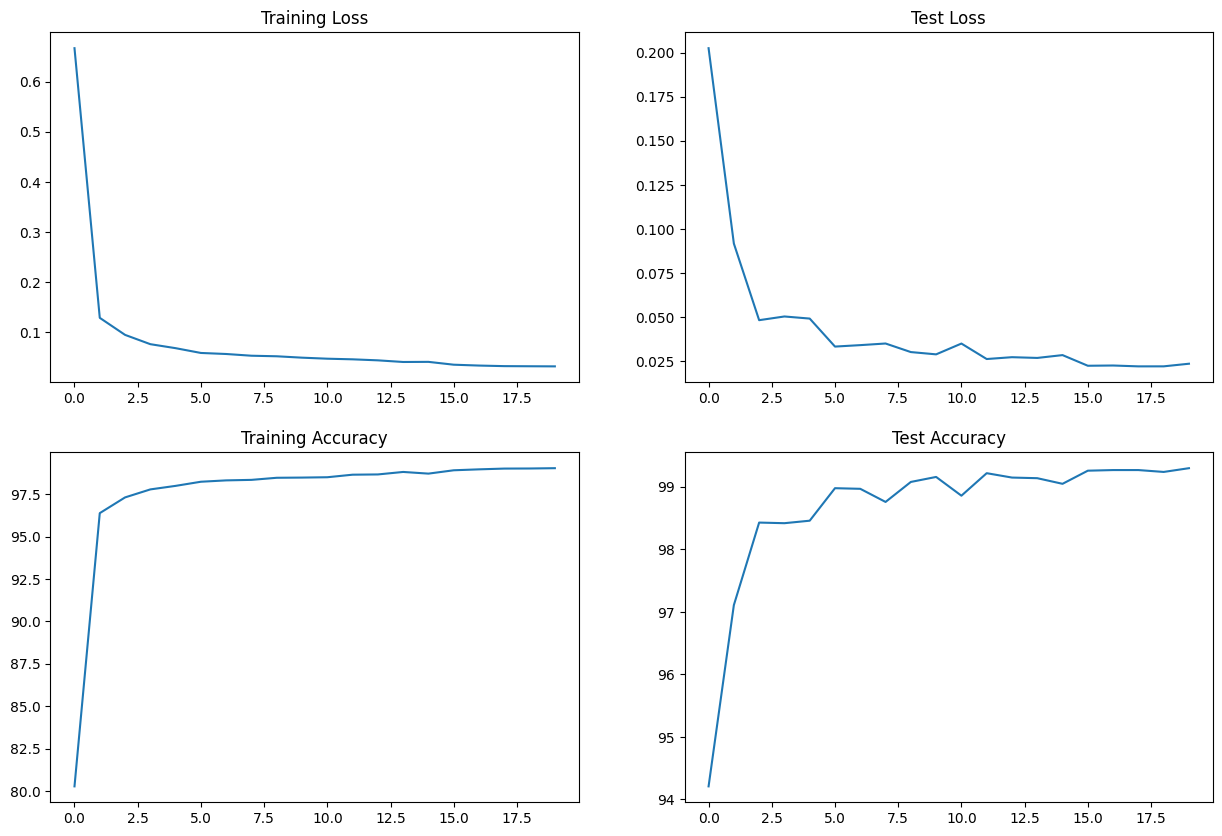

In [ ]:
# printTrainTest_LossAcc(train_losses,train_acc,test_losses,test_acc)